In [8]:
import json
from transformers import AutoTokenizer
from datasets import Dataset
from datasets import load_dataset
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /datadrive/pavan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [2]:
with open("/datadrive/pavan/az_storage/data_unorganized/stages/stage1/raw/context/all_data.jsonl", "r") as f:
    data = json.load(f)

In [2]:
#download a huggingface dataset named Pavankalyan/stage0_context_cleaned
ds0 = load_dataset("Pavankalyan/stage0_context_cleaned", split='train')
ds1 = load_dataset("Pavankalyan/stage1_context_cleaned", split='train')

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/17 [00:00<?, ?it/s]

In [17]:
from datasets import load_dataset
import pandas as pd
import textstat
from readability import Readability
from tqdm import tqdm
import numpy as np
import random

# Set seed for reproducibility
random.seed(42)

# Extract 'output' column
texts_0 = ds0['output']
texts_1 = ds1['output']

# Random sampling of 500 samples
sampled_0 = random.sample(texts_0, 5000)
sampled_1 = random.sample(texts_1, 5000)

In [18]:

# Function to compute readability metrics
def compute_metrics(text):
    try:
        r = Readability(text)
        metrics = {
            "flesch_kincaid": r.flesch_kincaid().score,
            "smog": r.smog().score,
            "coleman_liau": r.coleman_liau().score,
            "automated_readability": r.ari().score,
            "dale_chall": r.dale_chall().score,
            "gunning_fog": r.gunning_fog().score
        }
    except Exception:
        metrics = {
            "flesch_kincaid": np.nan,
            "smog": np.nan,
            "coleman_liau": np.nan,
            "automated_readability": np.nan,
            "dale_chall": np.nan,
            "gunning_fog": np.nan
        }
    return metrics

# Compute metrics
stats0 = [compute_metrics(text) for text in tqdm(sampled_0, desc="Processing stage0")]
stats1 = [compute_metrics(text) for text in tqdm(sampled_1, desc="Processing stage1")]

# Convert to DataFrames
df0 = pd.DataFrame(stats0)
df1 = pd.DataFrame(stats1)


Processing stage1: 100%|██████████| 5000/5000 [01:20<00:00, 61.84it/s]


In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Function to compute % change and absolute differences
def summarize_comparison(df0, df1):
    summary_0 = df0.describe()
    summary_1 = df1.describe()

    diff = summary_1 - summary_0
    percent_change = ((summary_1 - summary_0) / summary_0) * 100

    combined = pd.concat({
        "Stage 0": summary_0,
        "Stage 1": summary_1,
        "Abs Diff": diff,
        "% Change": percent_change
    }, axis=1)

    return combined

comparison = summarize_comparison(df0, df1)
print("\n=== Detailed Readability Metrics Comparison ===\n")
print(comparison.round(2))



=== Detailed Readability Metrics Comparison ===

             Stage 0                                                         \
      flesch_kincaid     smog coleman_liau automated_readability dale_chall   
count        4247.00  4247.00      4247.00               4247.00    4247.00   
mean            3.04     6.68         4.01                  1.49       6.71   
std             1.00     0.89         1.41                  1.22       0.91   
min            -0.48     3.13        -2.53                 -3.48       0.66   
25%             2.40     6.08         3.11                  0.68       6.22   
50%             3.06     6.59         4.08                  1.51       6.69   
75%             3.69     7.30         4.95                  2.29       7.21   
max             8.75    11.92        11.66                  8.63      12.39   

                         Stage 1                                              \
      gunning_fog flesch_kincaid     smog coleman_liau automated_readability   

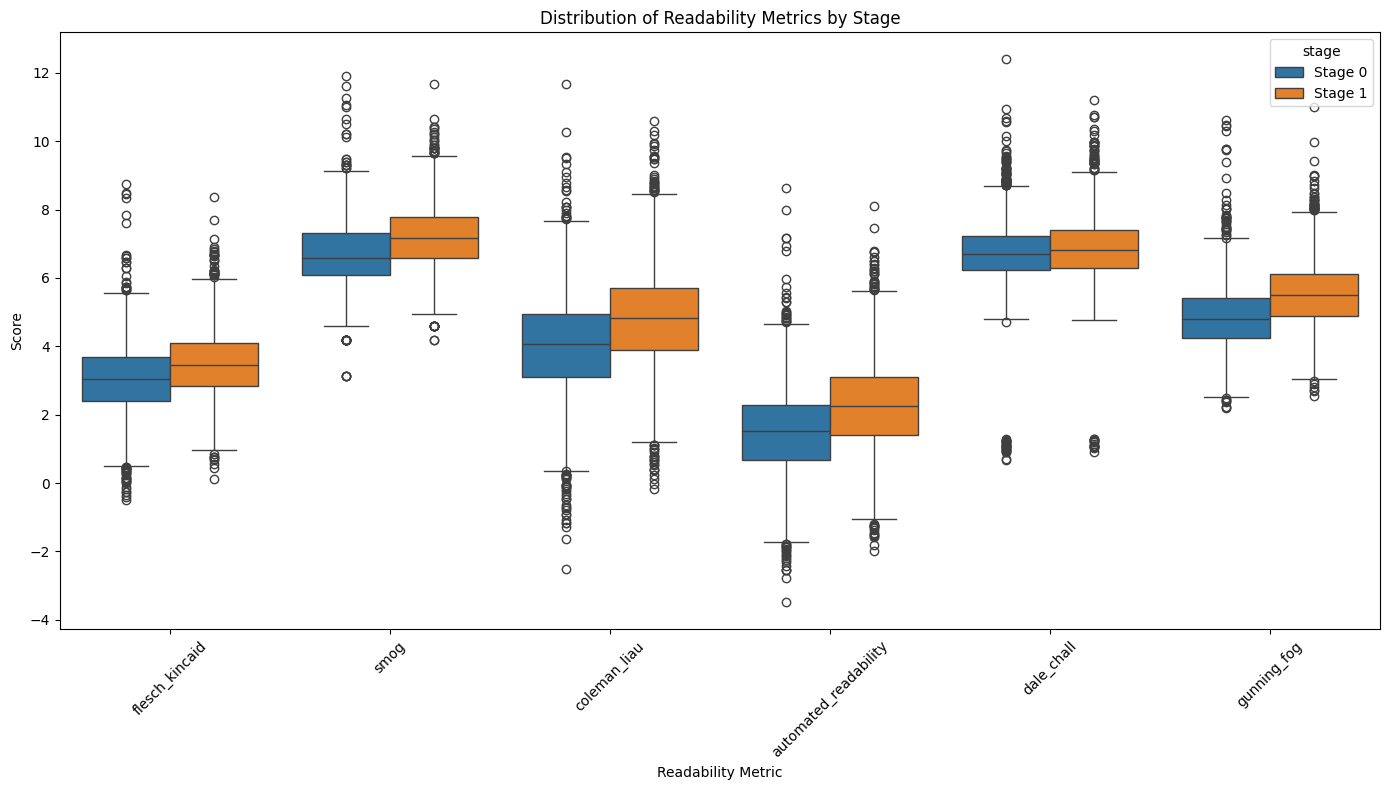

In [20]:
plt.figure(figsize=(14, 8))
merged_df = pd.concat([df0.assign(stage="Stage 0"), df1.assign(stage="Stage 1")])
sns.boxplot(data=merged_df.melt(id_vars="stage"), x="variable", y="value", hue="stage")
plt.xticks(rotation=45)
plt.title("Distribution of Readability Metrics by Stage")
plt.ylabel("Score")
plt.xlabel("Readability Metric")
plt.tight_layout()
plt.show()


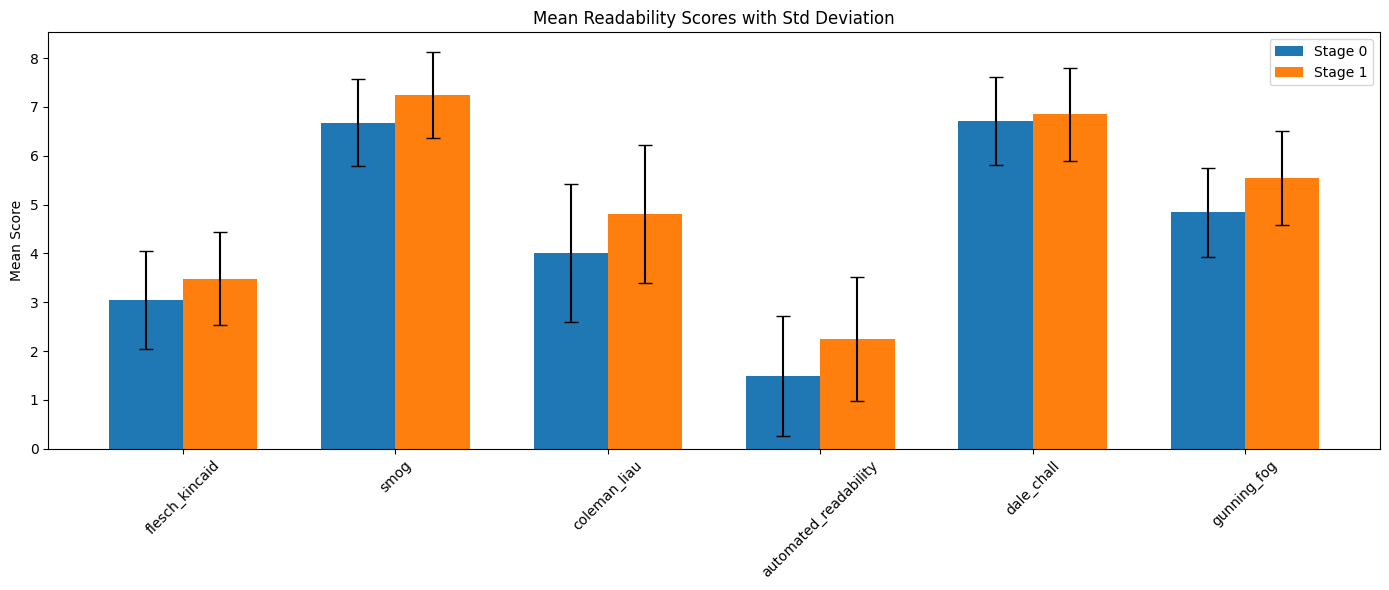

In [21]:
means_0 = df0.mean()
means_1 = df1.mean()
stds_0 = df0.std()
stds_1 = df1.std()

x = np.arange(len(means_0))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(x - width/2, means_0, width, yerr=stds_0, label='Stage 0', capsize=5)
ax.bar(x + width/2, means_1, width, yerr=stds_1, label='Stage 1', capsize=5)

ax.set_ylabel('Mean Score')
ax.set_title('Mean Readability Scores with Std Deviation')
ax.set_xticks(x)
ax.set_xticklabels(means_0.index, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


In [22]:
change_ranking = comparison["% Change"].loc["mean"].abs().sort_values(ascending=False)
print("\n=== Most Sensitive Readability Metrics ===")
print(change_ranking)



=== Most Sensitive Readability Metrics ===
automated_readability    50.665203
coleman_liau             19.856057
flesch_kincaid           14.569109
gunning_fog              14.423286
smog                      8.438628
dale_chall                2.074558
Name: mean, dtype: float64


In [30]:
from datasets import load_dataset
from semhash import SemHash


# Initialize a SemHash instance with the training data
semhash = SemHash.from_records(records=texts_0)

# Deduplicate the test data against the training data, optionally with a specific threshold
deduplicated_test_texts = semhash.deduplicate(records=texts_1, threshold=0.95)

In [34]:
len(deduplicated_test_texts.selected), len(texts_1), len(texts_0)

(3909142, 4038196, 3006990)

In [40]:
deduplicated_test_texts.duplicate_ratio

0.0319583299077113

In [26]:
len(texts_0), len(texts_1)

(3006990, 4038196)

In [42]:

deduplicated_texts = semhash.self_deduplicate(threshold=0.95)


In [43]:
deduplicated_texts.duplicate_ratio


0.1912330935586749

In [44]:
len(deduplicated_texts.selected), len(texts_0)

(2431954, 3006990)

In [4]:
tokenizer = AutoTokenizer.from_pretrained("Pavankalyan/TinyStoriesInstruct-tokenizer")

In [5]:
# Tokenize and count tokens
def count_tokens(batch):
    tokens = tokenizer(batch["text"], return_attention_mask=False, return_token_type_ids=False)
    return {"num_tokens": [len(input_ids) for input_ids in tokens["input_ids"]]}

In [6]:
# Convert to Dataset
dataset = Dataset.from_dict({"text": [item["output"]["generated_text"] for item in data]})

In [15]:
# Apply token counting
tokenized_dataset = dataset.map(count_tokens, batched=True, batch_size=1000)

# Sum total tokens
total_tokens = sum(tokenized_dataset["num_tokens"])
print(f"Total tokens: {total_tokens}")

Map:   0%|          | 0/3006990 [00:00<?, ? examples/s]

Total tokens: 1312271496


In [16]:
%pip install semhash

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 633.1/633.1 kB 34.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:

from semhash import SemHash

texts = dataset["text"]

# Initialize a SemHash instance
semhash = SemHash.from_records(records=texts)


model.safetensors:   0%|          | 0.00/30.2M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/271k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/202 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/684k [00:00<?, ?B/s]

In [47]:
# Deduplicate the texts
deduplicated_texts = semhash.self_deduplicate(threshold=0.99)

: 

In [28]:
deduplicated_texts.threshold

0.9

In [29]:
deduplicated_texts.exact_duplicate_ratio

3.325584720933558e-07

In [30]:
a = deduplicated_texts.duplicates
print(len(a))

2225141


In [45]:
len(a[200000].duplicates)

99

In [46]:
a[200000]

DuplicateRecord(record='Brrr! It’s a chilly day today. When it’s cold, we need to bundle up! Let’s think about all the things we can wear. First, a warm hat! It’s soft and fuzzy, and it keeps our ears from getting frosty. It feels like a hug for your head! Then, a big, comfy coat. This one is red, and it’s so fluffy inside. When I put it on, I feel like a bear getting ready for a long winter nap! \n\nWe also need mittens! My mittens are blue with little snowflakes on them. They keep our hands warm so we can build a snowman. When our hands are cold, they feel stiff and hard to move, but mittens make them nice and toasty. And don’t forget a scarf! A scarf wraps around our neck and keeps the cold air out. This one is striped, with purple and green. It tickles a little when I put it on. \n\nWhat else? Oh yes, warm socks! They are so important, especially when we’re playing in the snow. These socks are thick and woolly and keep our toes nice and warm. Imagine trying to build a snow fort wit

In [9]:
len(deduplicated_texts)

781849

In [12]:
deduplicated_texts[0]

"Leo loved playing with his red truck. It was his favorite! He zoomed it across the rug, making 'vroom vroom' sounds. Grandpa came to sit with him. “Wow, Leo, that truck looks very fast!” Grandpa said with a smile. Leo looked up at Grandpa and giggled, then went back to zooming his truck.\n\nGrandpa gently said, “Can I have a turn with the red truck, please?” Leo held onto the truck tightly. He didn't want to share! He shook his head and said, “No!” Grandpa didn’t seem upset. He just waited quietly. Leo kept playing, but he noticed Grandpa wasn't smiling anymore. He felt a little bit sad that Grandpa looked sad.\n\nLeo stopped zooming the truck. He looked at Grandpa and then back at the truck. He remembered his mommy telling him sharing makes people happy. Slowly, Leo handed the truck to Grandpa. Grandpa’s face lit up! “Thank you, Leo! You are a very kind helper.”\n\nGrandpa zoomed the truck across the rug, making his *own* 'vroom vroom' sounds. Leo laughed! It was fun to watch Grandpa

In [13]:
# Filter outliers
filtered_texts = semhash.self_filter_outliers().selected

In [14]:
len(filtered_texts)

2706290

In [23]:
filtered_texts[20]

{'text': 'Old MacDonald had a farm, E-I-E-I-O!\nAnd on that farm he had a cow, E-I-E-I-O!\nWith a moo moo here, and a moo moo there,\nHere a moo, there a moo, everywhere a moo moo!\nOld MacDonald had a farm, E-I-E-I-O!\n\nOld MacDonald had a farm, E-I-E-I-O!\nAnd on that farm he had a pig, E-I-E-I-O!\nWith an oink oink here, and an oink oink there,\nHere an oink, there an oink, everywhere an oink oink!\nOld MacDonald had a farm, E-I-E-I-O!\n\nOld MacDonald had a farm, E-I-E-I-O!\nAnd on that farm he had a duck, E-I-E-I-O!\nWith a quack quack here, and a quack quack there,\nHere a quack, there a quack, everywhere a quack quack!\nOld MacDonald had a farm, E-I-E-I-O!\n\nOld MacDonald had a farm, E-I-E-I-O!\nAnd on that farm he had a sheep, E-I-E-I-O!\nWith a baa baa here, and a baa baa there,\nHere a baa, there a baa, everywhere a baa baa!\nOld MacDonald had a farm, E-I-E-I-O!\n\nOld MacDonald had a farm, E-I-E-I-O!\nAnd on that farm he had a chicken, E-I-E-I-O!\nWith a cluck cluck here, 

In [ ]:

# Find representative texts
representative_texts = semhash.self_find_representative().selected